<a href="https://colab.research.google.com/github/mehrnazeraeisi/Digits/blob/main/Digits_KnnClassification_Modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

In [3]:
# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)


In [5]:

# [3] Load Wine dataset
data = load_digits()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
all_features = data.feature_names

In [6]:
# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, all_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)


🔎 Feature-wise Accuracy Ranking:
      Feature  Accuracy
61  pixel_7_5  0.247078
28  pixel_3_4  0.246522
36  pixel_4_4  0.245409
33  pixel_4_1  0.242627
20  pixel_2_4  0.242070
..        ...       ...
56  pixel_7_0  0.099610
24  pixel_3_0  0.099054
0   pixel_0_0  0.099054
32  pixel_4_0  0.099054
39  pixel_4_7  0.099054

[64 rows x 2 columns]


In [10]:
# [5] Group features based on accuracy thresholds
strong_features = feature_scores[feature_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.9]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.8]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.7]['Feature'].tolist()
medium_features_4 = feature_scores[feature_scores['Accuracy'] > 0.6]['Feature'].tolist()
medium_features_5 = feature_scores[feature_scores['Accuracy'] > 0.5]['Feature'].tolist()
medium_features_6 = feature_scores[feature_scores['Accuracy'] > 0.4]['Feature'].tolist()
medium_features_7 = feature_scores[feature_scores['Accuracy'] > 0.3]['Feature'].tolist()
medium_features_8 = feature_scores[feature_scores['Accuracy'] > 0.2]['Feature'].tolist()
medium_features_9 = feature_scores[feature_scores['Accuracy'] > 0.1]['Feature'].tolist()


poor_features = feature_scores[feature_scores['Accuracy'] <= 0.1]['Feature'].tolist()

In [11]:
# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [all_features, strong_features, medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5,medium_features_6, medium_features_7, medium_features_8, medium_features_9, poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['All Features', 'strong_features(over 0.95)', 'medium_features_1(over 0.9)', 'medium_features_2(over 0.8)',
          'medium_features_3(over 0.7)', 'medium_features_4(over 0.6)', 'medium_features_5(over 0.5)', 'medium_features_6(over 0.4)',
                      'medium_features_7(over 0.3)', 'medium_features_8(over 0.2)',  'medium_features_9(over 0.1)', 'poor_features(under 0.1)'],
    'Accuracy': acc_scores
})

print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)


📊 Grouped Feature Performance Summary:
                  Feature Group  Accuracy
0                  All Features  0.990540
1    strong_features(over 0.95)       NaN
2   medium_features_1(over 0.9)       NaN
3   medium_features_2(over 0.8)       NaN
4   medium_features_3(over 0.7)       NaN
5   medium_features_4(over 0.6)       NaN
6   medium_features_5(over 0.5)       NaN
7   medium_features_6(over 0.4)       NaN
8   medium_features_7(over 0.3)       NaN
9   medium_features_8(over 0.2)  0.943795
10  medium_features_9(over 0.1)  0.990540
11     poor_features(under 0.1)  0.099610


In [12]:
# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_8, medium_features_9, all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "medium_features_8": [],
        "medium_features_9": []
    }

    feature_groups = {
        "all_features": all_features,
        "medium_features_8": medium_features_8,
        "medium_features_9":  medium_features_9
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(10, 5))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

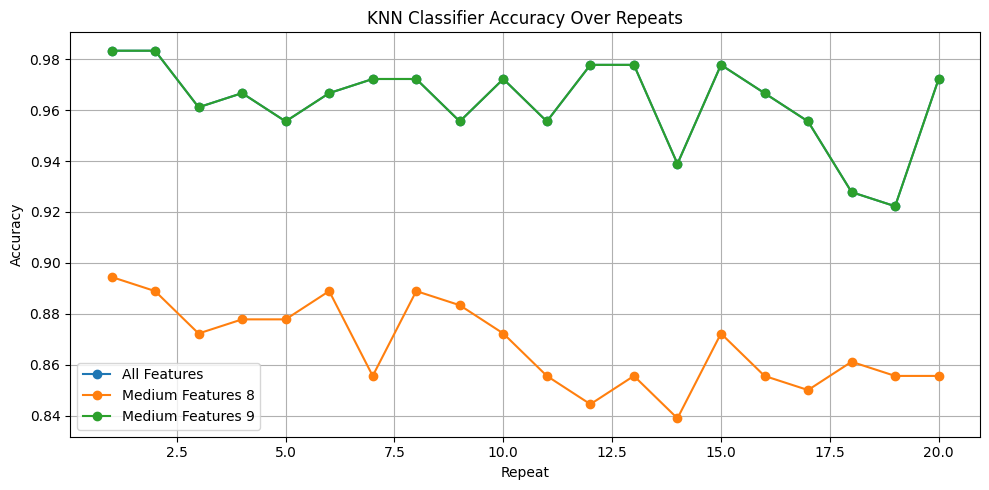

In [13]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_8, medium_features_9, all_features, test_size=0.10, n_repeats=20)



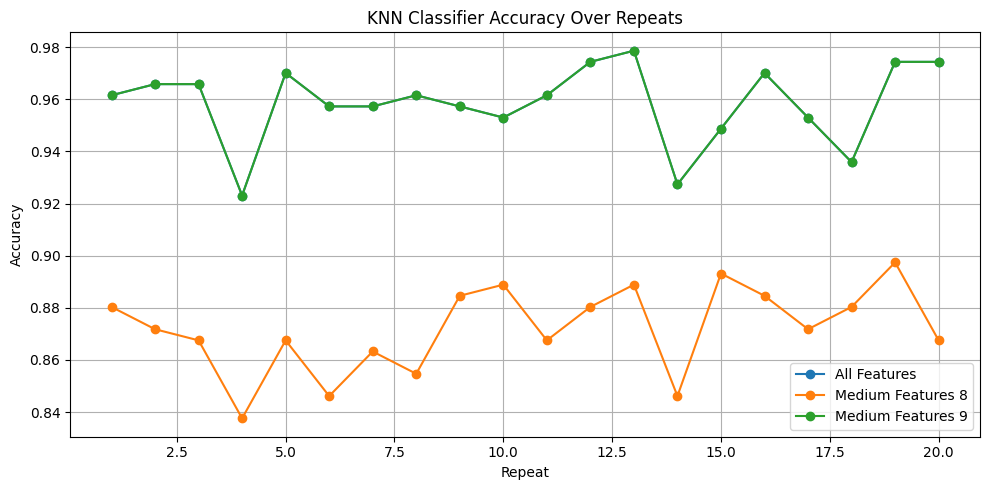

In [14]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_8, medium_features_9, all_features, test_size=0.13, n_repeats=20)


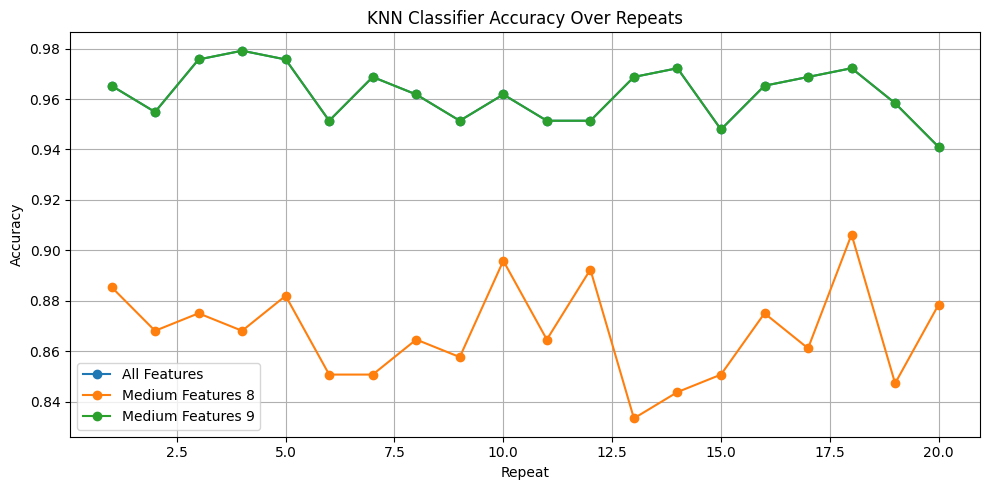

In [15]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_8, medium_features_9, all_features, test_size=0.16, n_repeats=20)


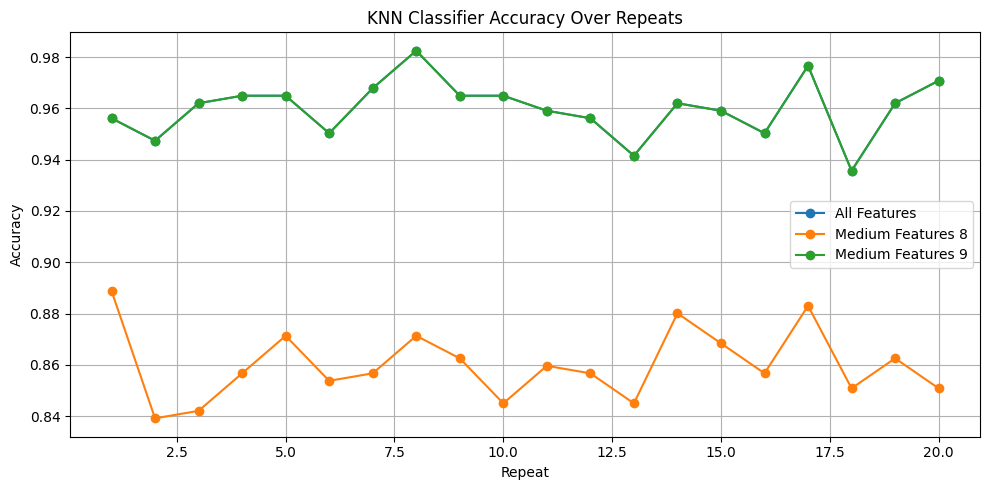

In [16]:
# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_8, medium_features_9, all_features, test_size=0.19, n_repeats=20)


🔎 Feature-wise Accuracy Ranking:
      Feature  Accuracy
61  pixel_7_5  0.247078
28  pixel_3_4  0.246522
36  pixel_4_4  0.245409
33  pixel_4_1  0.242627
20  pixel_2_4  0.242070
..        ...       ...
56  pixel_7_0  0.099610
24  pixel_3_0  0.099054
0   pixel_0_0  0.099054
32  pixel_4_0  0.099054
39  pixel_4_7  0.099054

[64 rows x 2 columns]

📊 Grouped Feature Performance Summary:
                  Feature Group  Accuracy
0                  All Features  0.990540
1    strong_features(over 0.95)       NaN
2   medium_features_1(over 0.9)       NaN
3   medium_features_2(over 0.8)       NaN
4   medium_features_3(over 0.7)       NaN
5   medium_features_4(over 0.6)       NaN
6   medium_features_5(over 0.5)       NaN
7   medium_features_6(over 0.4)       NaN
8   medium_features_7(over 0.3)       NaN
9   medium_features_8(over 0.2)  0.943795
10  medium_features_9(over 0.1)  0.990540
11     poor_features(under 0.1)  0.099610


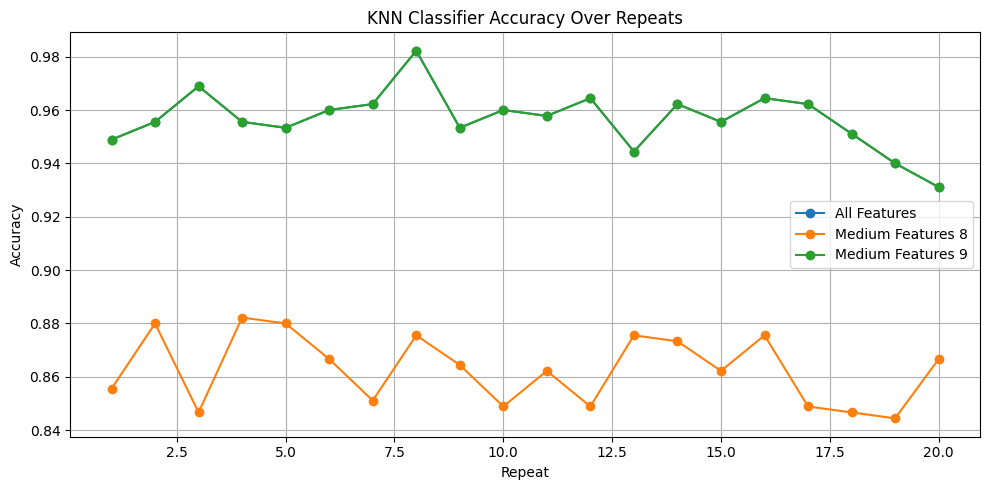

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# [1] Prioritize features based on single-feature KNN accuracy
def prioritize_features_by_accuracy(X, y, features):
    feature_scores = []
    knn = KNeighborsClassifier()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D shape
        knn.fit(X_feature, y)
        y_pred = knn.predict(X_feature)
        acc = accuracy_score(y, y_pred)
        feature_scores.append((feature, acc))

    df_scores = pd.DataFrame(feature_scores, columns=['Feature', 'Accuracy'])
    return df_scores.sort_values(by='Accuracy', ascending=False)

# [2] Safe accuracy computation for selected feature groups
def knn_accuracy(X, y, selected_features):
    if not selected_features:
        return np.nan
    model = KNeighborsClassifier()
    X_subset = X[selected_features]
    model.fit(X_subset, y)
    y_pred = model.predict(X_subset)
    return accuracy_score(y, y_pred)

# [3] Load Wine dataset
data = load_digits()
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
all_features = data.feature_names

# [4] Prioritize all features by single-feature accuracy
feature_scores = prioritize_features_by_accuracy(X_data, y_data, all_features)
print("🔎 Feature-wise Accuracy Ranking:")
print(feature_scores)

# [5] Group features based on accuracy thresholds
strong_features = feature_scores[feature_scores['Accuracy'] > 0.95]['Feature'].tolist()
medium_features_1 = feature_scores[feature_scores['Accuracy'] > 0.9]['Feature'].tolist()
medium_features_2 = feature_scores[feature_scores['Accuracy'] > 0.8]['Feature'].tolist()
medium_features_3 = feature_scores[feature_scores['Accuracy'] > 0.7]['Feature'].tolist()
medium_features_4 = feature_scores[feature_scores['Accuracy'] > 0.6]['Feature'].tolist()
medium_features_5 = feature_scores[feature_scores['Accuracy'] > 0.5]['Feature'].tolist()
medium_features_6 = feature_scores[feature_scores['Accuracy'] > 0.4]['Feature'].tolist()
medium_features_7 = feature_scores[feature_scores['Accuracy'] > 0.3]['Feature'].tolist()
medium_features_8 = feature_scores[feature_scores['Accuracy'] > 0.2]['Feature'].tolist()
medium_features_9 = feature_scores[feature_scores['Accuracy'] > 0.1]['Feature'].tolist()


poor_features = feature_scores[feature_scores['Accuracy'] <= 0.1]['Feature'].tolist()

# [6] Evaluate grouped features using multi-feature KNN accuracy
groups = [all_features, strong_features, medium_features_1, medium_features_2,
          medium_features_3, medium_features_4, medium_features_5 ,medium_features_6, medium_features_7, medium_features_8, medium_features_9 , poor_features]

acc_scores = [knn_accuracy(X_data, y_data, group) for group in groups]

# [7] Create summary table
summary_df = pd.DataFrame({
    'Feature Group': ['All Features', 'strong_features(over 0.95)', 'medium_features_1(over 0.9)', 'medium_features_2(over 0.8)',
          'medium_features_3(over 0.7)', 'medium_features_4(over 0.6)', 'medium_features_5(over 0.5)', 'medium_features_6(over 0.4)',
                      'medium_features_7(over 0.3)', 'medium_features_8(over 0.2)',  'medium_features_9(over 0.1)', 'poor_features(under 0.1)'],
    'Accuracy': acc_scores
})
print("\n📊 Grouped Feature Performance Summary:")
print(summary_df)

# [8] Final evaluation function: repeats KNN classification and plots accuracy over repeats
def evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_8 , medium_features_9,  all_features, test_size, n_repeats):
    accuracy_scores = {
        "all_features": [],
        "medium_features_8": [],
        "medium_features_9": []
    }

    feature_groups = {
        "all_features": all_features,
        "medium_features_8": medium_features_8,
        "medium_features_9":  medium_features_9
    }

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            k = int(np.sqrt(len(X_train)))
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train[group_features], y_train)
            y_pred = knn.predict(X_test[group_features])
            acc = accuracy_score(y_test, y_pred)
            accuracy_scores[group_name].append(acc)

    # Plotting accuracy per repeat
    x = np.arange(1, n_repeats + 1)
    plt.figure(figsize=(10, 5))
    for group_name, acc_list in accuracy_scores.items():
        plt.plot(x, acc_list, label=f"{group_name.replace('_', ' ').title()}", marker='o')
    plt.xlabel('Repeat')
    plt.ylabel('Accuracy')
    plt.title('KNN Classifier Accuracy Over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# [9] Run final evaluation
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_8, medium_features_9, all_features, test_size=0.25, n_repeats=20)


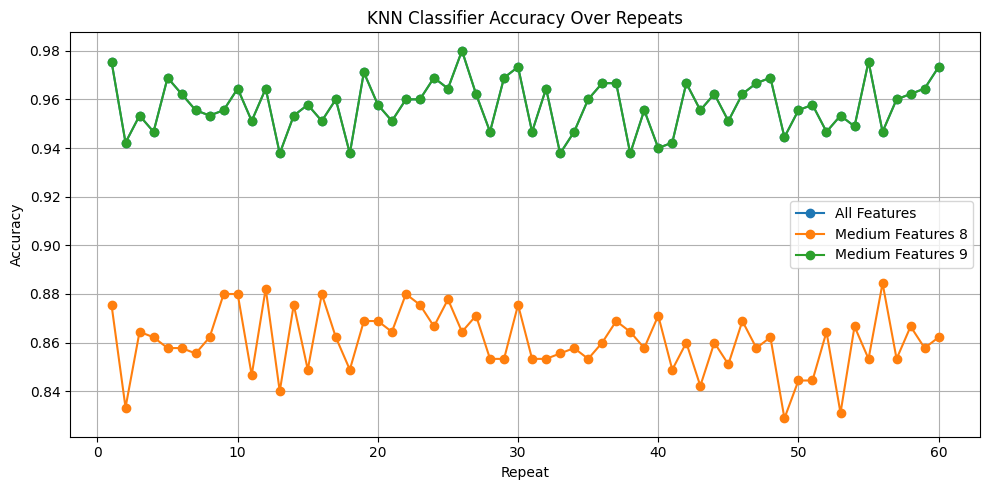

In [19]:
evaluate_knn_accuracy_by_groups(X_data, y_data, medium_features_8, medium_features_9, all_features, test_size=0.25, n_repeats=60)
